# Detecção de Moto com CNN + Transfer Learning

Este notebook treina um modelo para **detectar se há ou não uma moto** em uma imagem usando Transfer Learning com MobileNetV2.

In [26]:
%%capture
!pip install tensorflow matplotlib

In [83]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

Carregando o Dataset

In [28]:
img_size = (224, 224)
batch_size = 1  # Reduzido para se adequar ao dataset pequeno

# Gerador com aumento de dados e validação
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.4,  # Aproximadamente 2 imagens de validação se você tiver 5 de treino
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Carregamento dos dados
train_data = datagen.flow_from_directory(
    'data/train/',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='training',
    shuffle=True
)

val_data = datagen.flow_from_directory(
    'data/train/',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='validation',
    shuffle=False
)

Found 6 images belonging to 2 classes.
Found 4 images belonging to 2 classes.


## Construindo o Modelo (Transfer Learning)

In [29]:
# Modelo base com pesos pré-treinados e sem o topo
base_model = MobileNetV2(input_shape=img_size + (3,), include_top=False, weights='imagenet')
base_model.trainable = False  # Congela as camadas base

# Construção do modelo com pooling e camadas densas
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(64, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compilação do modelo
model.compile(optimizer=Adam(0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping para parar se a validação não melhorar
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

## Treinando o Modelo

In [30]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=10,  # Poucas épocas por causa do tamanho pequeno
    callbacks=[early_stop]
)

Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 665ms/step - accuracy: 0.6524 - loss: 0.4300 - val_accuracy: 0.5000 - val_loss: 0.6111
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 231ms/step - accuracy: 0.4190 - loss: 0.6269 - val_accuracy: 0.5000 - val_loss: 0.6985
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 223ms/step - accuracy: 0.7690 - loss: 0.4334 - val_accuracy: 0.7500 - val_loss: 0.4709
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 286ms/step - accuracy: 0.7690 - loss: 0.3442 - val_accuracy: 0.7500 - val_loss: 0.4986
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 223ms/step - accuracy: 1.0000 - loss: 0.3686 - val_accuracy: 1.0000 - val_loss: 0.2805
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 231ms/step - accuracy: 1.0000 - loss: 0.2869 - val_accuracy: 1.0000 - val_loss: 0.2026
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 220ms/step - accuracy: 1.0000 - loss: 0.1956 - val_accuracy: 1.0000 - val_loss: 0.3051
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 290ms/step - accuracy: 1.0000 - loss: 0.1089 - val_accuracy: 1.0000 - val_loss:

## Avaliação

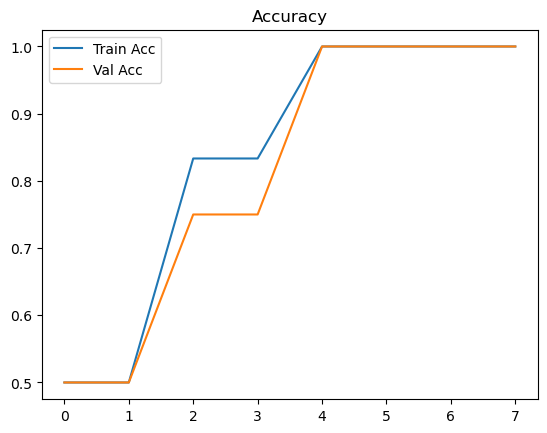

In [31]:
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title('Accuracy')
plt.show()

In [33]:
# Carregar os dados de teste
test_datagen = ImageDataGenerator(rescale=1./255)

test_data = test_datagen.flow_from_directory(
    'data/test/',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

# Avaliar o modelo nos dados de teste
loss, acc = model.evaluate(test_data)
print(f"Acurácia no conjunto de teste: {acc:.2%}")


Found 4 images belonging to 2 classes.
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 234ms/step - accuracy: 1.0000 - loss: 0.3558
Acurácia no conjunto de teste: 100.00%


## Salvando e carregando o modelo

In [35]:
model.save("modelo.keras")

In [84]:
model = load_model("modelo.keras")